In [1]:
import jax
# Enable Float64 for more stable matrix inversions.
jax.config.update("jax_enable_x64", True)

from dataclasses import dataclass
import warnings
from typing import List, Union
import pandas as pd
import cola

import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
    Num,
)
import tensorflow_probability.substrates.jax.bijectors as tfb

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from gpjax.distributions import GaussianDistribution
from gpjax.kernels import AdditiveKernel

import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams.update(mpl.rcParamsDefault)

#imports AdditiveConjugatePosterior
# from OAK import AdditiveConjugatePosterior

from pprint import pprint
import numpy as np
def calculate_nlpd(predictive_mean, predictive_stddev, actual_values):
    variance = predictive_stddev ** 2
    nlpd_sum = 0.5 * np.log(2 * np.pi * variance) + ((predictive_mean - actual_values) ** 2) / (2 * variance)
    total_nlpd = np.sum(nlpd_sum)
    return total_nlpd

## This is where I shall add in the dataset

This can be changed according to which data is useful and can be found in GPJAX/docs/examples/datasets



In [2]:
# dataset_path = "/home/sharmakd/python_dev/GPJax/docs/examples/datasets/real_estaate_evaluation/Real estate valuation data set.csv"
# mydata = pd.read_csv(dataset_path, sep=',')
# mydata.columns = ['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer', 'CoarseAggregate', 'FineAggregate', 'Age', 'Strength']

# mydata = mydata[:100]
# y = mydata['Y house price of unit area']
# X = mydata.drop(columns=['Y house price of unit area', 'No'])
# X = mydata[['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer']]

def g(x):
    return x

def h(x):
    return x

def f(x):
    return g(x[:, 0:1]) + h(x[:, 1:2]) #+ x[:, 2:3]



n, noise = 50, 0.001
key = jax.random.PRNGKey(np.random.randint(50))  # Replace 12345 with any desired seed value
X = jr.normal(key, (n, 2))
y = f(X) + jr.normal(key, (n, 1)) * noise

#Select Data wanted
X = jnp.array(X)
# y = jnp.array(y).reshape(-1, 1) 
D = gpx.Dataset(X, y)
feature_dimension = X.shape[1]

# Split the data into training and test sets
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.1, random_state=42)
print(Xtr.shape, Xte.shape, ytr.shape, yte.shape)

(45, 2) (5, 2) (45, 1) (5, 1)


In [3]:
# prepare some plotting utilities
NumPoints = 20
min, max = -4, 4

#Need to implement general nd mesh grid and 2d plot points to estimate points
# x1_plot, x2_plot, x3_plot = jnp.meshgrid(jnp.linspace(min,max,NumPoints), jnp.linspace(min,max,NumPoints),jnp.linspace(min,max,NumPoints))
# xplot2d = jnp.stack([x1_plot.reshape(-1), x2_plot.reshape(-1), x3_plot.reshape(-1)]).T # array of points to test on  make the 2 feature dimension
# xplot1d = jnp.stack([jnp.linspace(-min,max,NumPoints) for _ in range(feature_dimension)]).T # [NumPoints, feature dimension]
# print(xplot2d[0:10])

def mesh2d(active_dimensions: list[int] = [], min = min, max = max, NumPoints = NumPoints):
    if len(active_dimensions) not in [1,2]:
        raise ValueError("Only 1 or 2 active dimensions are supported")
    xn_plot = []
    for i in range(feature_dimension):
        if i in active_dimensions:
            xn_plot += [jnp.linspace(min, max, NumPoints)]
        else:
            xn_plot += [jnp.array([0])]
    print(xn_plot)
    xn_meshgrid = jnp.meshgrid(*xn_plot)
    xplot2d = jnp.stack([x.reshape(-1) for x in xn_meshgrid], axis=-1)
    return xplot2d

# xn_plot = [jnp.linspace(min, max, NumPoints) for _ in range(feature_dimension)]
# xn_meshgrid = jnp.meshgrid(*xn_plot)
# xplot2d = jnp.stack([x.reshape(-1) for x in xn_meshgrid], axis=-1)

xplot1d = jnp.stack([jnp.linspace(min, max, NumPoints) for _ in range(feature_dimension)]).T
x1_plot, x2_plot = jnp.meshgrid(jnp.linspace(min, max, NumPoints), jnp.linspace(min, max, NumPoints))

def contour_plot(Z, ax):
    Z = Z.reshape(NumPoints, NumPoints)
    cp = ax.contourf(x1_plot, x2_plot, Z)
    ax.scatter(X[:,0], X[:,1], c="red", marker="x", label="data")
    ax.set_xlim(min,max)
    ax.set_ylim(min,max)



[Array([-4.        , -3.57894737, -3.15789474, -2.73684211, -2.31578947,
       -1.89473684, -1.47368421, -1.05263158, -0.63157895, -0.21052632,
        0.21052632,  0.63157895,  1.05263158,  1.47368421,  1.89473684,
        2.31578947,  2.73684211,  3.15789474,  3.57894737,  4.        ],      dtype=float64), Array([-4.        , -3.57894737, -3.15789474, -2.73684211, -2.31578947,
       -1.89473684, -1.47368421, -1.05263158, -0.63157895, -0.21052632,
        0.21052632,  0.63157895,  1.05263158,  1.47368421,  1.89473684,
        2.31578947,  2.73684211,  3.15789474,  3.57894737,  4.        ],      dtype=float64)]


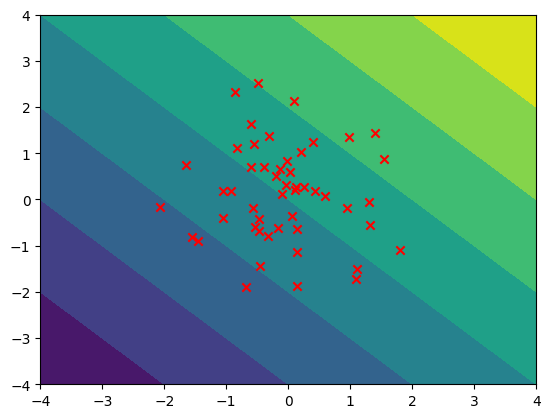

In [4]:
fig, ax = plt.subplots()
xplot2d = mesh2d(active_dimensions=[0,1])
contour_plot(f(xplot2d), ax)
plt.show()

## This step is to test datasets to see if they need scaling or transforming

In [5]:
class AdditiveConjugatePosterior(gpx.gps.ConjugatePosterior):
    r"""        
    Build an additive posterior from an additive kernel and a Gaussian likelihood. We have included an
    additional method to allow predictions for specific additive components, as specified by a
    component_list, e.g. [0, 1] corresponds to the second order interaction between zeroth and first inputs.
    """

    def __post__init__(self):
        assert isinstance(self.prior.kernel, AdditiveKernel), "AdditiveConjugatePosterior requires an AdditiveKernel"

    def predict_additive_component(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: gpx.Dataset,
        component_list: List[List[int]]
    ) -> GaussianDistribution:
        r"""Get the posterior predictive distribution for a specific additive component."""
        specific_kernel = self.prior.kernel.get_specific_kernel(component_list)
        return self.predict(test_inputs, train_data, kernel_with_test = specific_kernel)

    def get_sobol_index(self, train_data: gpx.Dataset, component_list: List[int]) -> ScalarFloat:
        """ Return the sobol index for the additive component corresponding to component_list. """
        component_posterior = self.predict_additive_component(train_data.X, train_data, component_list)
        full_posterior= self.predict(train_data.X, train_data) # wasteful as only need means
        return jnp.var(component_posterior.mean()) / jnp.var(full_posterior.mean())

In [6]:
x_scaler = StandardScaler().fit(Xtr)
scaled_Xtr = x_scaler.transform(Xtr)
scaled_Xte = x_scaler.transform(Xte)

In [7]:
print(scaled_Xtr[:15])

[[ 1.22573709 -0.31619499]
 [-1.57725558 -1.01169854]
 [-0.26584283 -0.89509639]
 [ 0.3564924   0.85589813]
 [-0.44276525  2.28429243]
 [ 1.4061205  -1.58675139]
 [-0.24131439  1.18086089]
 [-0.58461412  0.52807347]
 [ 0.27793319 -1.93460888]
 [-0.43669901 -0.54349902]
 [ 0.24727888  0.05110157]
 [ 1.63902102 -0.20137001]
 [-0.87913903  2.0978896 ]
 [-1.09746763 -0.51708177]
 [ 0.61850191  0.04169611]]


In [8]:
y_scaler = StandardScaler().fit(ytr)
scaled_ytr = y_scaler.transform(ytr)
scaled_yte = y_scaler.transform(yte)

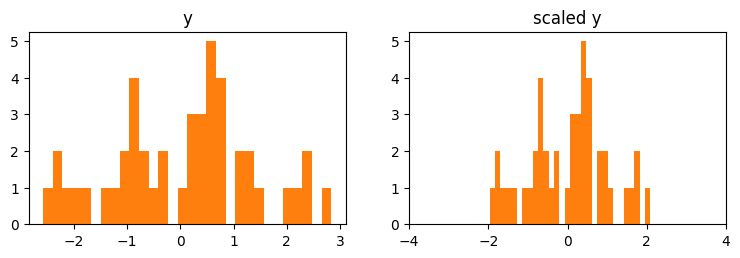

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 2.5))
ax[0].hist(ytr.reshape(1, -1), bins=30, color=cols[1])
ax[0].set_title("y")
ax[1].hist(scaled_ytr, bins=30, color=cols[1])
ax[1].set_title("scaled y")
ax[1].set_xlim(-4, 4)
plt.show()

This looks good! 

## Work on the Posterior Now!

Now lets try on the dataset. we fit additive models of `max_interaction_depth` 0 (i.e. a constant model), 1 and 2.

We can also look at the individual additive components learned by the second order model

In [10]:
def plot_posterior_with_components2d(opt_posterior, active_dimensions: list[int] = [0, 1], axis_to_plot = 0):
        if len(active_dimensions) not in [1,2]:
            raise ValueError("Only 1 or 2 active dimensions are supported")
        contour_plot(opt_posterior.predict_additive_component(
                mesh2d(active_dimensions=active_dimensions),
                D,
                [0, 1]
        ).mean(), ax[axis_to_plot])


In [11]:
import os

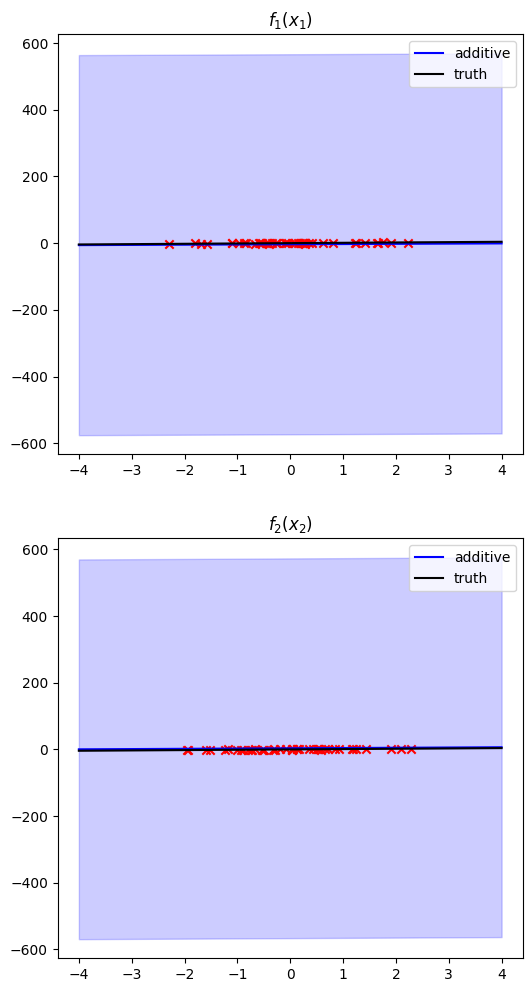

In [13]:
D = gpx.Dataset(X=scaled_Xtr, y=scaled_ytr)
# noise = 0.01
meanf = gpx.mean_functions.Zero()
base_kernels = [gpx.kernels.RBF(active_dims=[i], lengthscale=jnp.array([1.0])) for i in range(feature_dimension)]
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)
obj = gpx.objectives.ConjugateLOOCV(negative=True)
maximum_interaction_depth = 2
kernel = AdditiveKernel(
    kernels=base_kernels,
    interaction_variances=jnp.array([1.0]*(maximum_interaction_depth+1)) * jnp.var(D.y), 
    max_interaction_depth=maximum_interaction_depth, 
    )
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
posterior = AdditiveConjugatePosterior(prior =prior, likelihood=likelihood)
opt_posterior, history = gpx.fit_scipy(model=posterior, objective=obj, train_data=D, verbose=False)

# plotting util
def plot_posterior_with_components(opt_posterior, sobol=False):
    fig, ax = plt.subplots(ncols=1, nrows=feature_dimension, figsize=(6, 6 * feature_dimension))
    for i in range(feature_dimension): # make 1d plots of 1d interactions
        posterior = opt_posterior.predict_additive_component(xplot1d, D, [i])
        mean, std = posterior.mean(), posterior.stddev()
        ax[i].plot(xplot1d[:,i], mean, color="blue", label="additive")
        ax[i].fill_between(xplot1d[:,i], mean - 2 * std,mean + 2 * std, alpha=0.2, color="blue")
        ax[i].set_title(f"$f_{i+1}(x_{i+1})$" if not sobol else f"$f_{i+1}(x_{i+1})$ has sobol ${opt_posterior.get_sobol_index(D, [i]):.2f}$")
        truth = g(xplot1d[:,i]) if i==0 else h(xplot1d[:,i])
        ax[i].plot(xplot1d[:,i], truth, color="black", label="truth")
        ax[i].legend()
        ax[i].scatter(scaled_Xtr[:,i], scaled_ytr, c="red", marker="x", label="data")
        # print(i)
    # pprint(opt_posterior.__dict__)

    # plot 2d interaction
    # ax[2].set_title(f"$f_3(x_1,x_2)$" if not sobol else f"$f_3(x_1,x_2)$ has sobol ${opt_posterior.get_sobol_index(D, [0, 1]):.2f}$")
    # contour_plot(opt_posterior.predict_additive_component(xplot2d, D, [0, 1]).mean(), ax[2])

# plot learned additive components
plot_posterior_with_components(opt_posterior)
plt.show()

Although the mean predictions are reasonably close to the true values of the additive components $x_1^2$ and $-2x_2$ there is a large ammount of uncertainty. [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf) argue that the high uncertainty is a consequence of the lack of exisiting of an unique additive decomposition. For example
$$
f(x_1,x_2) = (f(x_1) + \Delta_1(x_1)) + (f(x_2) + \Delta_2(x_2)) + (f_{12}(x_1, x_2) - \Delta_1(x_1) - \Delta_2(x_2))
$$
is a valid additive decomposition for any functions $\Delta_1(x_1)$ and $\Delta_2(x_2)$. 

## Roll on the "Orthogonal Additive Kernel"

To mitigate the problem of identifiability, [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf) apply an additional constraint to each base kernel so that the integral of each function $\{f_i\}_{i=1}^D$ (with respect to some chosen measure) is zero, thus resulting in a unique decomposition. When $f$ has a non-zero mean, a constant offset is included.

More precisely, we "orthogonalise"  base kernel $i$ by conditioning on the event $\int f_i(x_i)p(x_i)dx_i = 0$. Fortunateky, conditioning a GP on a linear operator also results in a GP and so (for certain base measures $p(x_i)$) our model remains tractible. In our implentation below, we assume a unit Gaussian input measure, so you may achieve better results if you transform your inputs to match.

In [ ]:
@dataclass()
class OrthogonalRBF(gpx.kernels.AbstractKernel):
    r"""todo only for unit gaussian input measure and zero mean."""
    name: str = "OrthogonalRBF"
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = gpx.param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )

    def __post_init__(self):
        warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute an orthogonal RBF kernel between a pair of arrays."""
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.exp(-0.5 * ((x - y) / self.lengthscale) ** 2) # [d]
        ks -=  self._cov_x_s(x) * self._cov_x_s(y) / self._var_s() # [d]
        return jnp.prod(ks)
    
    def _cov_x_s(self,x):
        l2 = self.lengthscale ** 2
        return jnp.sqrt(l2 / (l2 + 1.0)) * jnp.exp(-0.5 * (x ** 2) / (l2 + 1.0)) # [d]
        
    def _var_s(self):
        return  jnp.sqrt(self.lengthscale ** 2 / (self.lengthscale ** 2 + 2.0)) # [d]


Now, lets use this new kernel to recreate the plots from above.

In [ ]:
# base_kernels = [OrthogonalRBF(active_dims=[0], lengthscale=jnp.array([1.0])), OrthogonalRBF(active_dims=[1], lengthscale=jnp.array([1.0]))]

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,5))
# for i in [0,1,2]:
    
#     kernel = AdditiveKernel(
#         kernels=base_kernels,
#         interaction_variances=jnp.array([1.0]*(i+1)) * jnp.var(D.y), 
#         max_interaction_depth=i, 
#         )

#     prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
#     posterior = AdditiveConjugatePosterior(prior =prior, likelihood=likelihood)
#     opt_posterior, history = gpx.fit_scipy(model=posterior, objective=obj, train_data=D, verbose=False)
#     contour_plot(opt_posterior.predict(xplot2d, D).mean(), ax[i])
#     ax[i].set_title(f"max interaction={i}")

# # plot additive components
# plot_posterior_with_components(opt_posterior, sobol=True)
# plt.show()

By "orthogonalising" our kernel and so providing an identifiable decomposition, we have greatly reduced the uncertainty of our additve model and have much tighter estimates of the univariate additive components. Note that the constant gap between the truth and our estimated $f_0$ is expected and is accounted for by the not-plotted constant interaction.